In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#import cartopy.crs as ccrs
import numpy as np
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import seaborn as sns
import xarray as xr

import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:

class ConvLSTMCell(nn.Module):
    """ Inspired by https://github.com/automan000/Convolution_LSTM_PyTorch. """
    def __init__(self, input_channels, hidden_channels, kernel_size, GPU = False):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0 # figure out what this does

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        """
        i - input gate
        f - forget gate
        c - (?) gate
        o - output gate

        les her https://hackernoon.com/understanding-architecture-of-lstm-cell-from-scratch-with-code-8da40f0b71f4

        """

        # TWO D convolution since we have a grid.
        # Why the bias in a certain way.
        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).cpu() #cuda() here
            self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).cpu()#.cuda()
            self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).cpu()#.cuda()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cpu(), #cuda(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cpu() )#cuda())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)

        return outputs, (x, new_c)

In [4]:
def create_ML_repo(start = "2012-01-01", stop = "2013-01-01", season = "SON", 
                  era_path = '/uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/'):
    """
    Want all year put season to "".
    """
    q   = xr.open_dataset(glob.glob(era_path + "*_q_*" + season +".nc")[0]).q.values
    r   = xr.open_dataset(glob.glob(era_path + "*_r_*"+ season +".nc")[0]).r.values
    tcc = xr.open_dataset(glob.glob(era_path + "*tcc*"+ season +".nc")[0]).tcc.values
    sp  = xr.open_dataset(glob.glob(era_path + "*sp*"+ season +".nc")[0]).sp.values
    t2m = xr.open_dataset(glob.glob(era_path + "*t2m*"+ season +".nc")[0]).t2m.values
    assert np.shape(q) == np.shape(r) == np.shape(tcc) == np.shape(sp) == np.shape(t2m)
    
    nbr_times, nbr_lats, nbr_lon = np.shape(q)
    train = []
    true  = tcc
    for i in range(nbr_times):
        one_timestep = np.array([q[i], r[i], tcc[i], t2m[i] ])
        #print(one_timestep.shape)
        train.append(one_timestep)
    return np.array(train), true

In [ ]:
def batch_normalize():
    pass

def init_kernel():
    pass

def init_bias():
    pass

In [5]:
train, test = create_ML_repo()

# SET UP MODEL

In [15]:
convlstm = ConvLSTM(input_channels=512, hidden_channels=[128, 64, 64, 32, 1], kernel_size = 3, step=5,
                    effective_step=[4]).cpu()

loss_fn = torch.nn.MSELoss()

input = Variable(torch.randn(1, 512, 64, 32)).cpu()
target = Variable(torch.randn(1, 1, 64, 32)).double().cpu()

output = convlstm(input)
output = output[0][0].double()
res = torch.autograd.gradcheck(loss_fn, (output, target), eps=1e-6, raise_exception=True)
print(res)

AssertionError: 

In [16]:
diff = (output - target).detach().numpy()

In [14]:
diff.shape

(1, 32, 64, 32)

In [21]:
diff[0][0][:][:].shape

(64, 32)

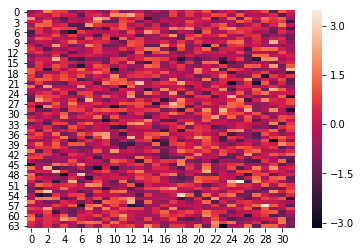

In [22]:
sns.heatmap(diff[0][0][:][:])